# Measurement Type and Outscaling Analysis

Previously, we used two different types of output scaling: Skolik and Normal:

- Normal outscaling: Here, each expectation value (which is between -1 and 1) is multiplied by a classical trainable weight.
- Skolik Outscaling: Here, each expectation value is first normalized to be between 0 and 1, and then multiplied by a classical trainable weight.

However, we multiplied each expectation value by its own weight. This is what we call **Global Scaling**. However, we also want to introduce a different approach, where we multiply all expectation values by the same weight. This is what we call **Local Scaling**. Thus, we have 4 different types of output scaling:

- **LocalSkolik**
- **GlobalSkolik**
- **LocalNormal**
- **GlobalNormal**

Furthermore, we also want to use a different type of measurement, which is the **global measurement**. In this type of measurement, we first apply a CNOT chain before measuring the last qubit and we use $- <Z>$ for action 1 and $<Z>$ for action 2. However, we also want to try the same type of measurement but without the CNOTchain beforee measuring the last qubit. This is what we call **local measurement**.

In this notebook, we will analyse the performance of every single measurement and outscaling type. Those were the parameters that varied. All the other hyperparameters were the following:
```# Parameters for the VQC
    num_qubits = 4
    num_layers = 5
    num_actions = 2
    circuit_arch = "skolik"
    data_reuploading = sys.argv[1]
    qubits = cirq.GridQubit.rect(1, num_qubits)
    #ops = [cirq.Z(q) for q in qubits]
    #observables = [ops[0]*ops[1], ops[2]*ops[3]]tt
    ops = cirq.Z(qubits[-1])
    observables = [-ops,+ops]
    measurement = sys.argv[6]
    rescaling_type = sys.argv[5]

    # Parameters for the training
    gamma = 0.99
    num_episodes = 3000
    max_memory_length = 10000 # Maximum replay length
    replay_memory = deque(maxlen=max_memory_length)
    epsilon = 1.0  # Epsilon greedy parameter
    epsilon_min = 0.01  # Minimum epsilon greedy parameter
    decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
    batch_size = 16
    steps_per_update = 1 # Train the model every x steps
    steps_per_target_update = 1 # Update the target model every x steps

    # Prepare the optimizers

    optimizer_in = None if sys.argv[1] == "v0" else tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

    # Assign the model parameters to each optimizer
    w_in = None if sys.argv[1] == "v0" else 1
    w_var = 0
    w_out = 1 if sys.argv[1] == "v0" else 2

    #Choose the environment
    environment = "CartPole-v0"
    input_encoding = sys.argv[3]
    early_stopping = False
    acceptance_reward = 195
    necessary_episodes = 25
```

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
v0_global_measurements = []
v2_global_measurements = []

for i in range(1,11):
    with open(f"Results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/lastZ_obs/skolik_optimal_hyper/agent{i}.pkl", 'rb') as f:
        v0_global_measurements.append(pickle.load(f))
    with open(f"Results/continuous/skolik_arch/baseline/localskolik_outscaling/lastZ_obs/skolik_optimal_hyper/agent{i}.pkl", 'rb') as f:
        v2_global_measurements.append(pickle.load(f))

[]

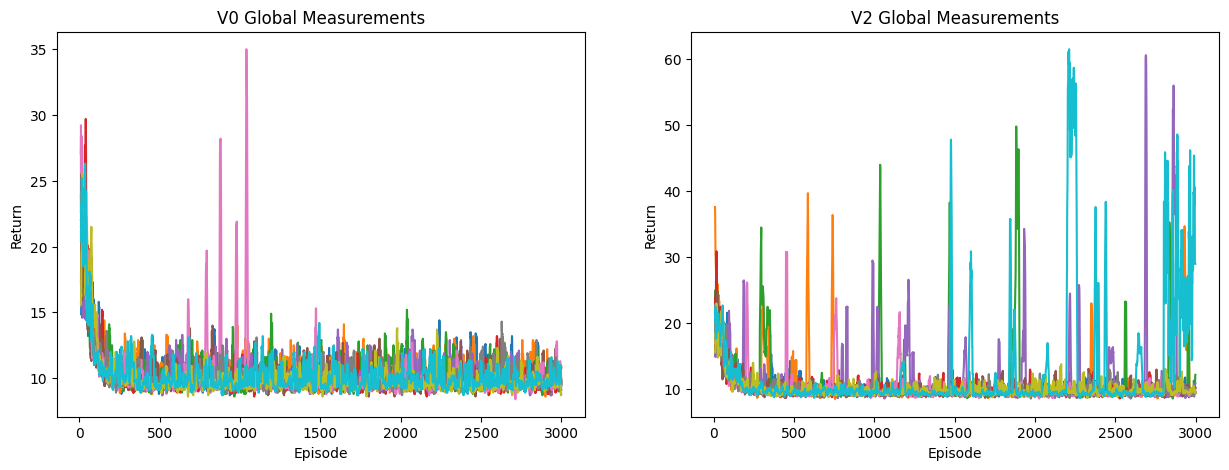

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(10):
    axs[0].plot(pd.Series(v0_global_measurements[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[1].plot(pd.Series(v2_global_measurements[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")

axs[0].set_title("V0 Global Measurements")
axs[1].set_title("V2 Global Measurements")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Return")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Return")

plt.plot()

In [4]:
v0_global_measurements[0].keys()

dict_keys(['episode_reward_history', 'gradients', 'loss_array', 'q_values_array', 'weights'])

In [5]:
q_values_v0 = [v0_global_measurements[i]["q_values_array"] for i in range(10)]
q_values_v2 = [v2_global_measurements[i]["q_values_array"] for i in range(10)]

In [6]:
q_values_v0[0][50]

array([[-0.0281526 , -0.1132526 ],
       [-0.02785521, -0.11205625],
       [-0.0281526 , -0.1132526 ],
       [ 0.041583  ,  0.16728057],
       [ 0.08075228,  0.32485116],
       [-0.04079824, -0.1641236 ],
       [-0.04465095, -0.17962237],
       [-0.02785521, -0.11205625],
       [ 0.041583  ,  0.16728057],
       [-0.01647834, -0.06628924],
       [ 0.01061036,  0.04268348],
       [ 0.08721881,  0.3508648 ],
       [ 0.03623911,  0.1457831 ],
       [ 0.03205085,  0.12893453],
       [ 0.041583  ,  0.16728057],
       [ 0.01061036,  0.04268348]], dtype=float32)

In [7]:
action_0 = 0
action_1 = 0

for i in range(16):
    if (q_values_v0[0][0][i][0] > q_values_v0[0][0][i][1]):
        action_0 +=1
    else:
        action_1 +=1

action_1

16

In [8]:
#An action is chosen based on the q_values of the current state. More specifically, the action with the highest q_value is chosen.
#Thus, I want to know what action, 0 or 1, is chosen most often overall for the V0 and V2 models

In [9]:
action_0_count_v0 = 0
action_1_count_v0 = 0
action_0_count_v2 = 0
action_1_count_v2 = 0

for i in range(10):
    for j in range(30000):
        for k in range(16):
            if (q_values_v0[i][j][k][0] > q_values_v0[i][j][k][1]):
                action_0_count_v0 += 1
            elif (q_values_v0[i][j][k][0] < q_values_v0[i][j][k][1]):
                action_1_count_v0 += 1
            if (q_values_v2[i][j][k][0] > q_values_v2[i][j][k][1]):
                action_0_count_v2 += 1
            elif (q_values_v2[i][j][k][0] < q_values_v2[i][j][k][1]):
                action_1_count_v2 += 1

In [10]:
print(f"The number of times action 0 was chosen for V0 is {action_0_count_v0} and the number of times action 1 was chosen is {action_1_count_v0}")
print(f"The number of times action 0 was chosen for V2 is {action_0_count_v2} and the number of times action 1 was chosen is {action_1_count_v2}")

The number of times action 0 was chosen for V0 is 2469589 and the number of times action 1 was chosen is 2330382
The number of times action 0 was chosen for V2 is 2280972 and the number of times action 1 was chosen is 2518978


In [11]:
#Now I the percentage of times action 0 was chosen for V0 and V2

In [12]:
#Now I want the percentages of times each action was chosen
print("Action 0 was chosen {}% of the time in the V0 models".format(action_0_count_v0/(action_0_count_v0 + action_1_count_v0)*100))
print("Action 0 was chosen {}% of the time in the V2 models ".format(action_0_count_v2/(action_0_count_v2 + action_1_count_v2)*100))

Action 0 was chosen 51.4500816775768% of the time in the V0 models
Action 0 was chosen 47.520745007760496% of the time in the V2 models 


In [13]:
weights_v0 = [v0_global_measurements[i]["weights"] for i in range(10)]
weights_v2 = [v2_global_measurements[i]["weights"] for i in range(10)]

In [14]:
#Let's just look at the outscaling weights of the V0 and V2 models
outscaling_weights_v0 = [weights_v0[i][2] for i in range(10)]
outscaling_weights_v2 = [weights_v2[i][2] for i in range(10)]

In [15]:
outscaling_weights_v0

[array([[-41.22273 ,  41.029545]], dtype=float32),
 array([[-21.96561 ,  22.633305]], dtype=float32),
 array([[ 25.87856 , -25.864351]], dtype=float32),
 array([[-53.647194,  53.653812]], dtype=float32),
 array([[ 30.139927, -30.173828]], dtype=float32),
 array([[ 32.159534, -32.13079 ]], dtype=float32),
 array([[ 47.93403, -48.06897]], dtype=float32),
 array([[ 38.84667 , -38.929832]], dtype=float32),
 array([[-35.78398 ,  35.795525]], dtype=float32),
 array([[ 33.934692, -34.02222 ]], dtype=float32)]

In [16]:
outscaling_weights_v2

[array([[-38.201466,  38.196262]], dtype=float32),
 array([[ 111.98104, -114.58845]], dtype=float32),
 array([[ 782.2785 , -779.49084]], dtype=float32),
 array([[ 36.664234, -36.828316]], dtype=float32),
 array([[ 628.8025, -626.2703]], dtype=float32),
 array([[ 44.81679, -44.72082]], dtype=float32),
 array([[-88.895744,  89.74403 ]], dtype=float32),
 array([[ 33.845543, -33.853756]], dtype=float32),
 array([[-25.988543,  26.200033]], dtype=float32),
 array([[-595.7582,  597.1477]], dtype=float32)]

In [17]:
path_v2 = "Results/global_measurement/v2/"
path = "Results/observables/"
filepath = "CartPolev0_Skolik_Arch_v0_ls_optimal_hyper_skolik_outscaling_1.pkl"
localnormal_global = []
localnormal_local = []
localskolik_local = []
localskolik_global = []
globalnormal_global = []
globalnormal_local = []
globalskolik_local = []
globalskolik_global = []


for i in range(1,6):
    with open(path_v2 + f"CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling_{i}.pkl", 'rb') as f:
        localnormal_global.append(pickle.load(f))

for i in range(1,6):
    with open(path + f"local_normal_local/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling_{i}.pkl", 'rb') as f:
        localnormal_local.append(pickle.load(f))
    with open(path + f"local_skolik_local/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling_{i}.pkl", 'rb') as f:
        localskolik_local.append(pickle.load(f))
    with open(path + f"local_skolik_global/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling_{i}.pkl", 'rb') as f:
        localskolik_global.append(pickle.load(f))
    with open(path + f"global_normal_global/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling_{i}.pkl", 'rb') as f:
        globalnormal_global.append(pickle.load(f))
    with open(path + f"global_normal_local/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling_{i}.pkl", 'rb') as f:
        globalnormal_local.append(pickle.load(f))
    with open(path + f"global_skolik_local/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling_{i}.pkl", 'rb') as f:
        globalskolik_local.append(pickle.load(f))
    with open(path + f"global_skolik_global/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling_{i}.pkl", 'rb') as f:
        globalskolik_global.append(pickle.load(f))
    

[]

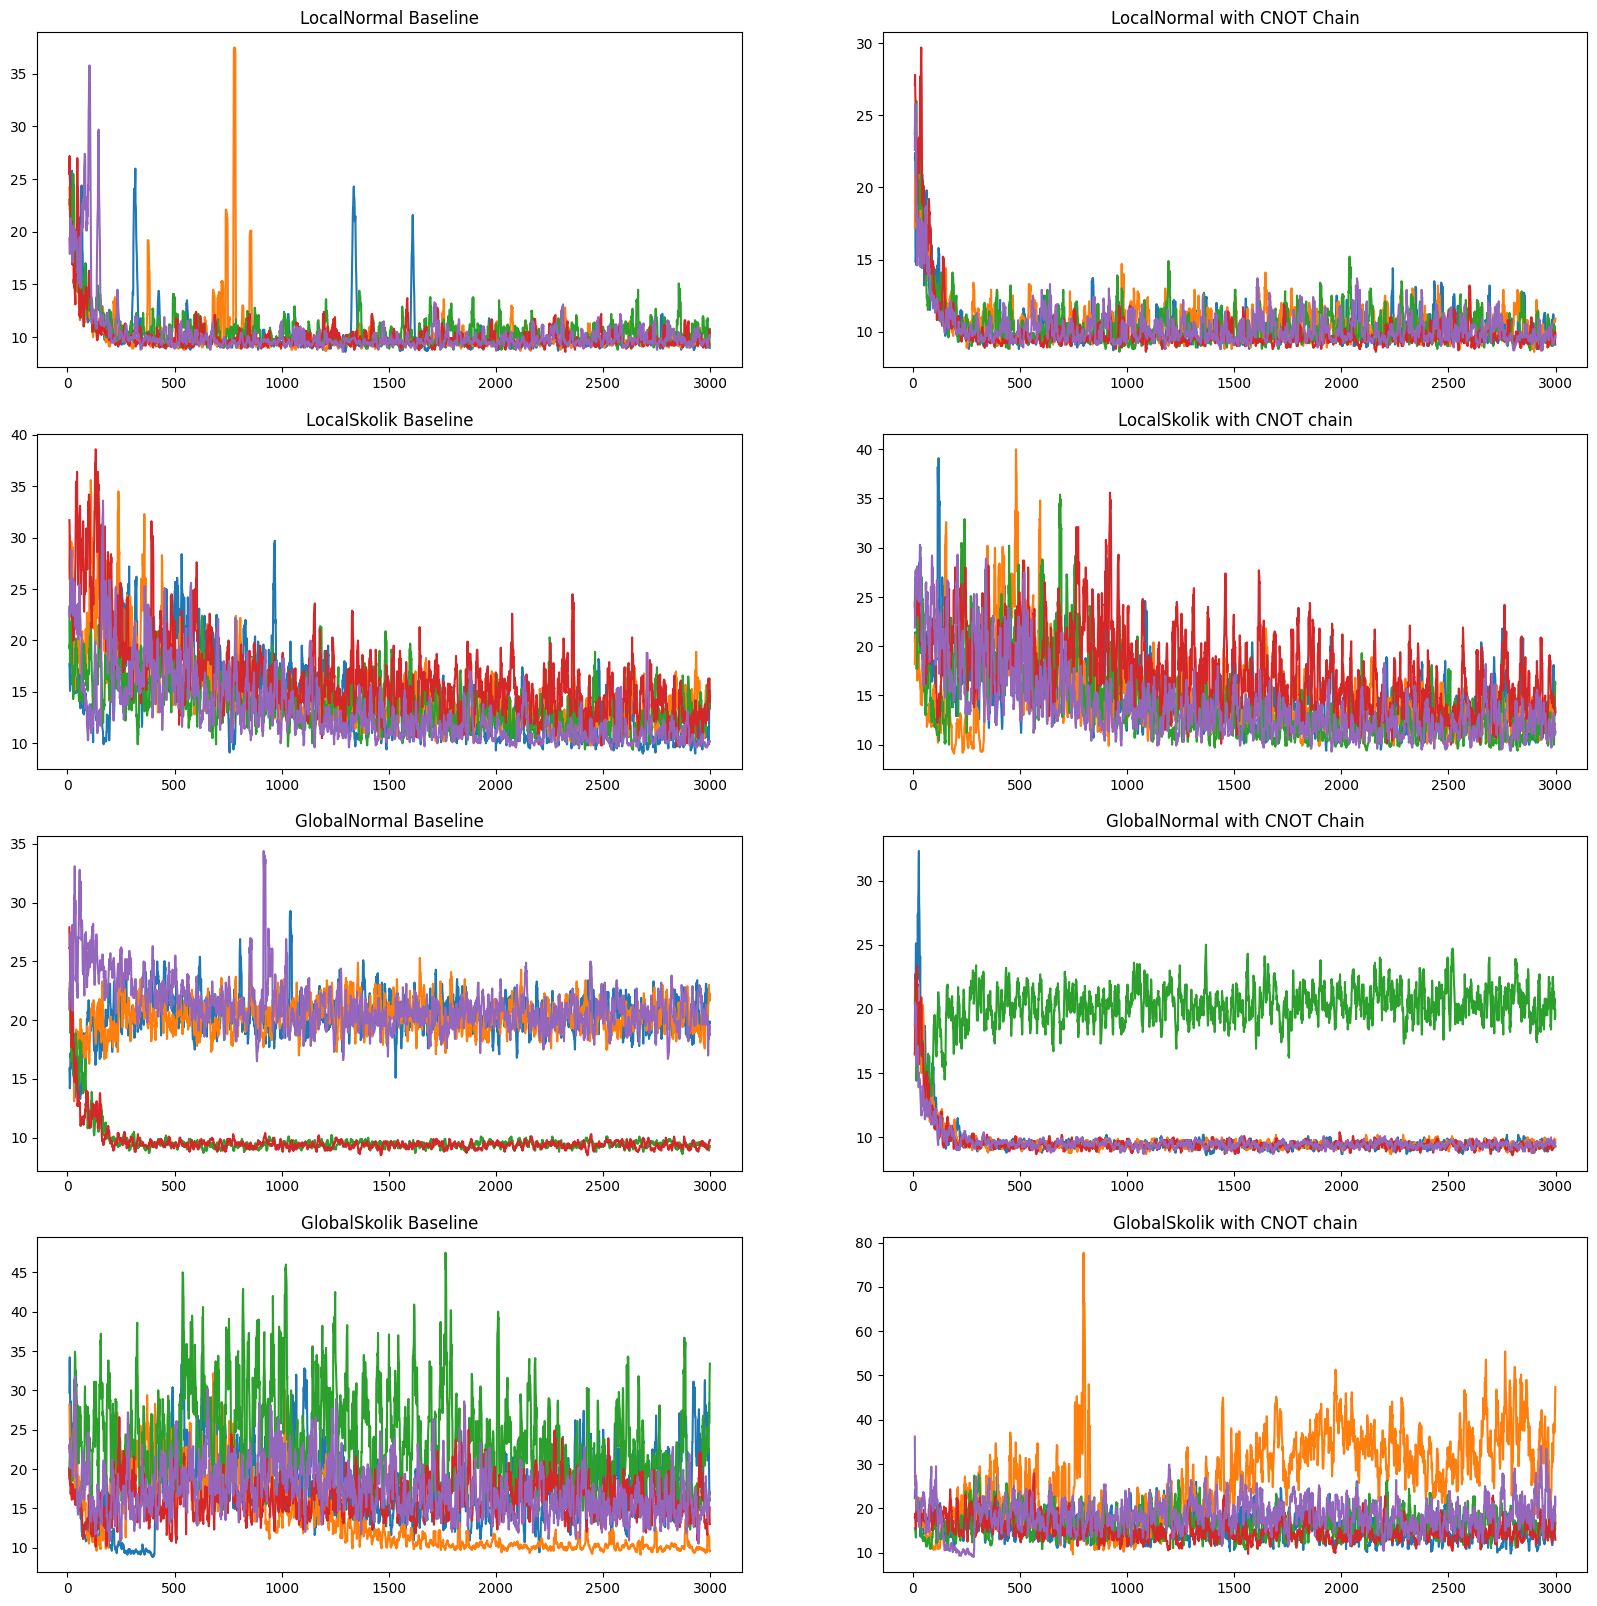

In [18]:
fig, axs = plt.subplots(4, 2, figsize = (20,20))

for i in range(5):
    axs[0,1].plot(pd.Series(localnormal_global[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[0,0].plot(pd.Series(localnormal_local[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[1,0].plot(pd.Series(localskolik_local[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[1,1].plot(pd.Series(localskolik_global[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[2,1].plot(pd.Series(globalnormal_global[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[2,0].plot(pd.Series(globalnormal_local[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[3,0].plot(pd.Series(globalskolik_local[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[3,1].plot(pd.Series(globalskolik_global[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")

axs[0,1].set_title("LocalNormal with CNOT Chain")
axs[0,0].set_title("LocalNormal Baseline")
axs[1,0].set_title("LocalSkolik Baseline")
axs[1,1].set_title("LocalSkolik with CNOT chain")
axs[2,1].set_title("GlobalNormal with CNOT Chain")
axs[2,0].set_title("GlobalNormal Baseline")
axs[3,0].set_title("GlobalSkolik Baseline")
axs[3,1].set_title("GlobalSkolik with CNOT chain")

plt.plot()

Now I ran the models from the third row once again but with more stable hyperparameters, specifically with train_every = 10 steps and update_every = 30 steps to try and stabilize the optimization process. The results are the following:

In [19]:
path = "Results/observables/stable/"
filepath = "CartPolev0_Skolik_Arch_v0_ls_optimal_hyper_skolik_outscaling_1.pkl"
stable_globalnormal_global = []
stable_globalnormal_local = []

for i in range(1,6):
    with open(path + f"global_normal_global/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling_{i}.pkl", 'rb') as f:
        stable_globalnormal_global.append(pickle.load(f))
    with open(path + f"global_normal_local/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling_{i}.pkl", 'rb') as f:
        stable_globalnormal_local.append(pickle.load(f))
    

[]

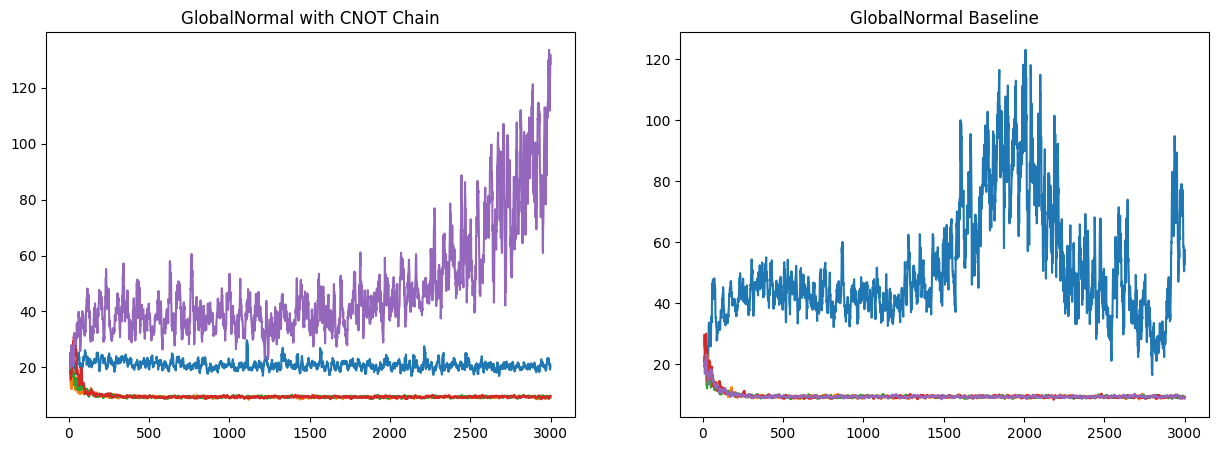

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(5):
    axs[0].plot(pd.Series(stable_globalnormal_global[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[1].plot(pd.Series(stable_globalnormal_local[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")

axs[0].set_title("GlobalNormal with CNOT Chain")
axs[1].set_title("GlobalNormal Baseline")

plt.plot()


As we can see, it seems like one agent for the baseline model and another for the CNOT chain model were able to learn something. However, the other 4 agents basically learned nothing at all. This is very weird, why would some agents learn, some of them even being able to collect over 100 rewards, while others dont learn anything at all? I should study this further by running these models with different hyperparameters. Maybe even do a cross-validation to find the best hyperparameters for each model.

# Gradients

André has told me that one of the reasons why these models mught not be learning is due to the variance and mean of the gradients of their parameters, since global measurements lead to Barren Plateaus. To study this further, I will analyse the mean and variance of the gradients of these models and then compare it with the gradients of the models without these types of measurements.

In [25]:
from analysis_functions import Analysis

In [26]:
number_of_agents = 5
path_local_measurement = 'Results/input_encoding/c/'
filename_local_measurement = 'CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling'

analysis_local_measurement = Analysis(path_local_measurement, filename_local_measurement, number_of_agents)

In [27]:
path_global_measurement = "Results/observables/"

filename_globalnormal_local = "global_normal_local/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling"
filename_globalnormal_global = "global_normal_global/CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling"

analysis_globalnormal_local = Analysis(path_global_measurement, filename_globalnormal_local, number_of_agents)
analysis_globalnormal_global = Analysis(path_global_measurement, filename_globalnormal_global, number_of_agents)

In [28]:
local_measurement_mean, local_measurement_std = analysis_local_measurement.get_gradients_all_params()
globalnormal_local_mean, globalnormal_local_std = analysis_globalnormal_local.get_gradients_all_params()
globalnormal_global_mean, globalnormal_global_std = analysis_globalnormal_global.get_gradients_all_params()

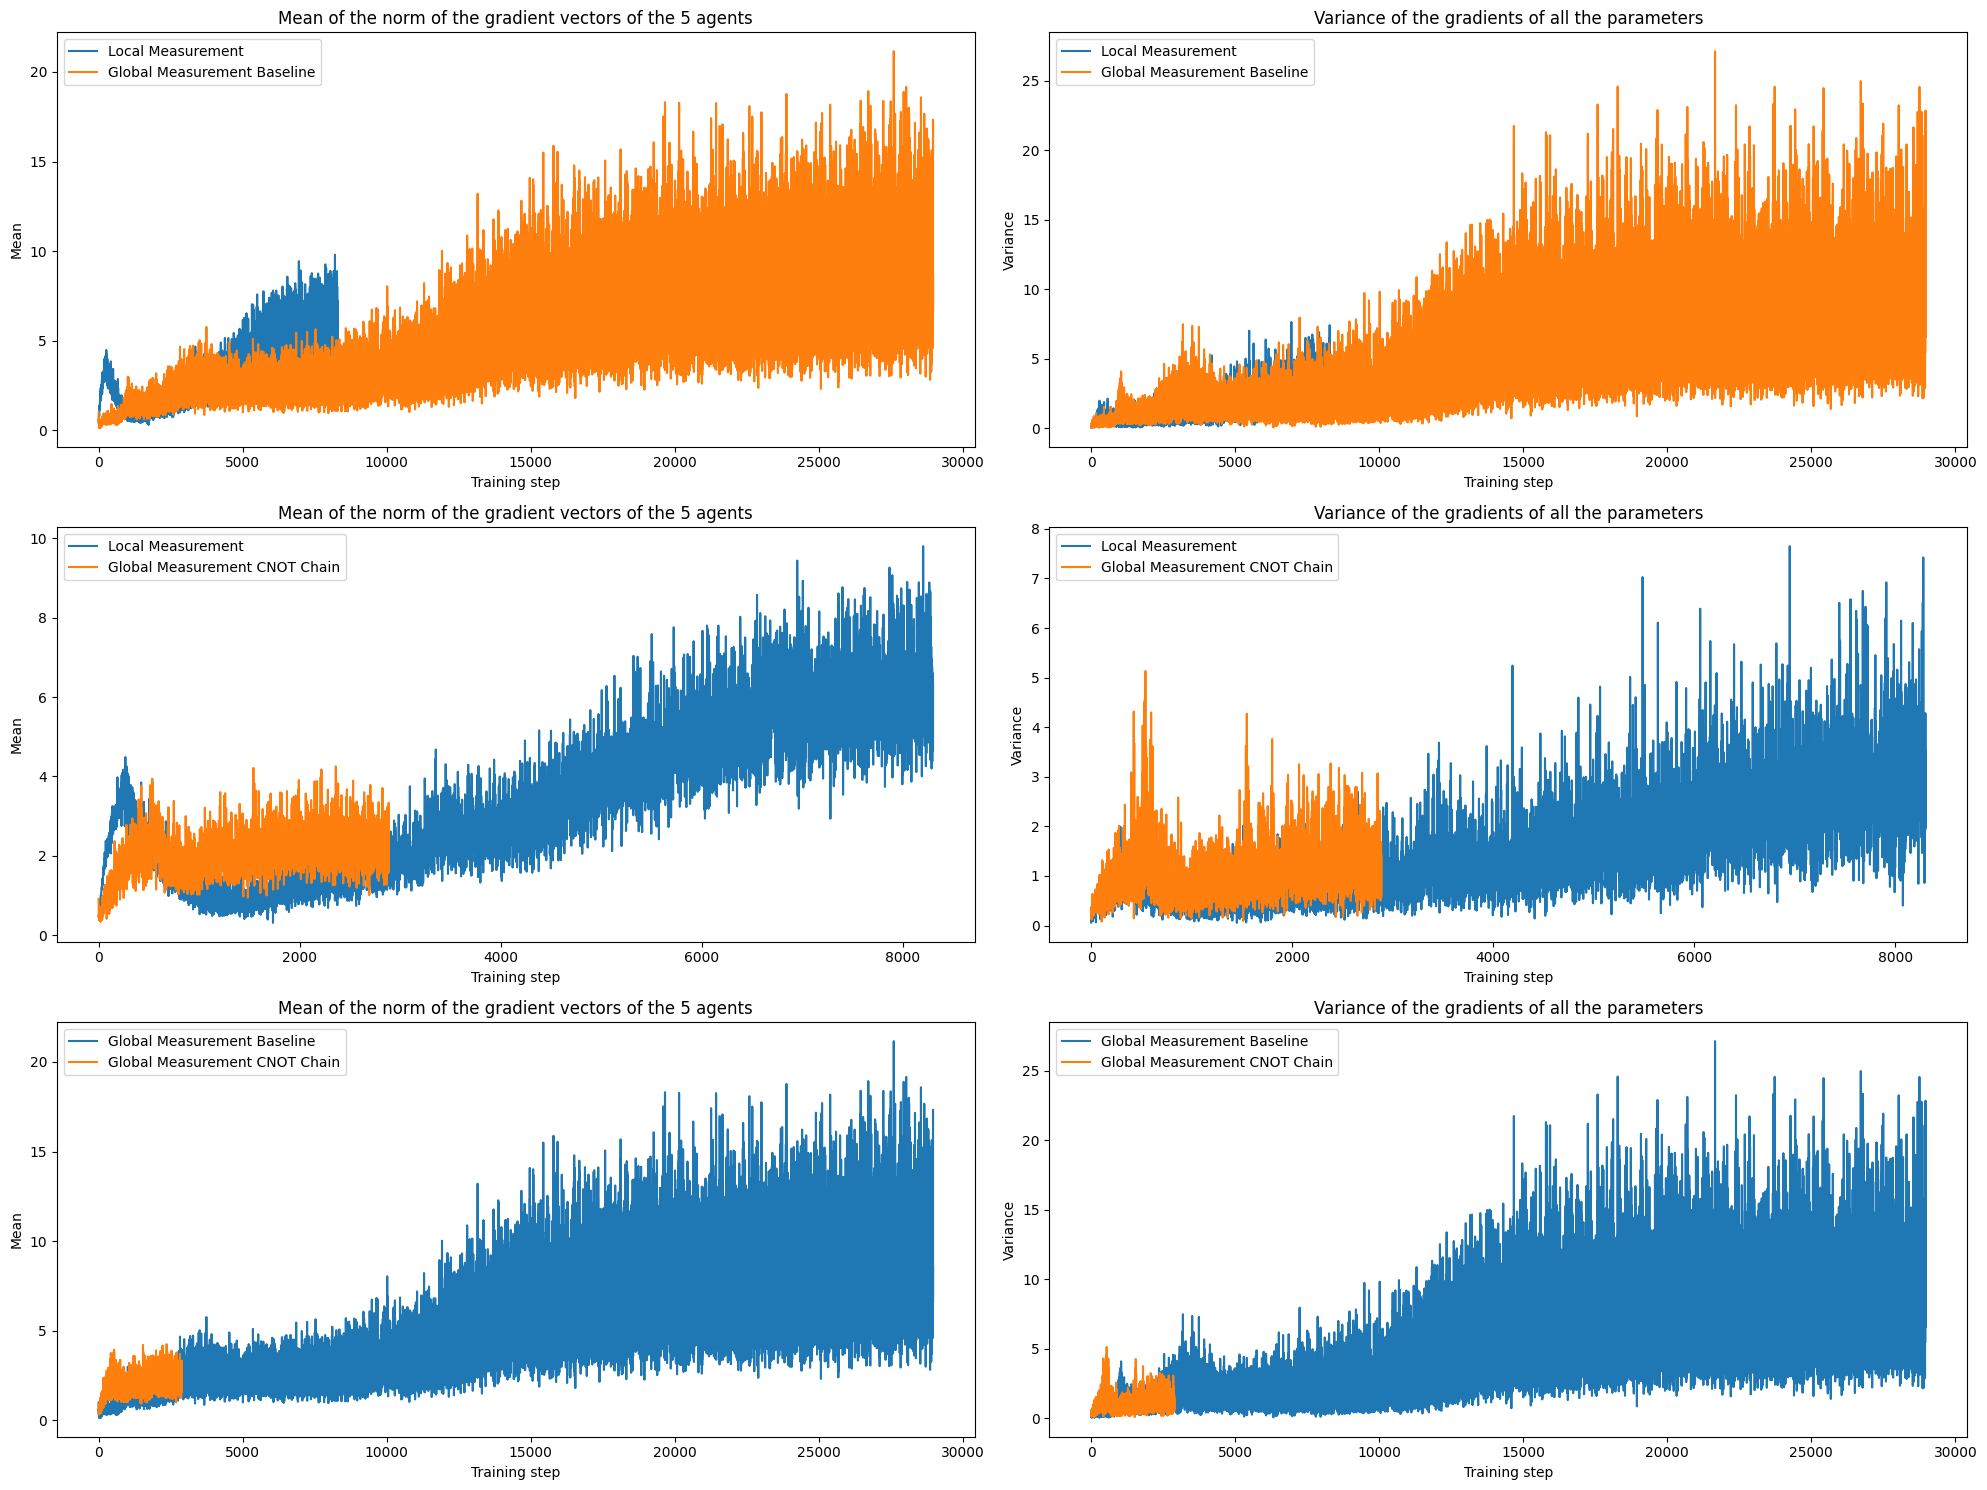

In [29]:
#Now let's plot the mean and variance of the gradients for the V0, V1 and V2 models in the same plot

fig, axs = plt.subplots(3,2, tight_layout=True, figsize=(20, 15))

axs[0,0].set_title("Mean of the norm of the gradient vectors of the 5 agents")
axs[0,0].set_xlabel("Training step")
axs[0,0].set_ylabel("Mean")
axs[0,0].plot(local_measurement_mean, label = "Local Measurement")
axs[0,0].plot(globalnormal_local_mean, label = "Global Measurement Baseline")
axs[0,0].legend()

axs[0,1].set_title("Variance of the gradients of all the parameters")
axs[0,1].set_xlabel("Training step")
axs[0,1].set_ylabel("Variance")
axs[0,1].plot(local_measurement_std, label = "Local Measurement")
axs[0,1].plot(globalnormal_local_std, label = "Global Measurement Baseline")
axs[0,1].legend()


axs[1,0].set_title("Mean of the norm of the gradient vectors of the 5 agents")
axs[1,0].set_xlabel("Training step")
axs[1,0].set_ylabel("Mean")
axs[1,0].plot(local_measurement_mean, label = "Local Measurement")
axs[1,0].plot(globalnormal_global_mean, label = "Global Measurement CNOT Chain")
axs[1,0].legend()

axs[1,1].set_title("Variance of the gradients of all the parameters")
axs[1,1].set_xlabel("Training step")
axs[1,1].set_ylabel("Variance")
axs[1,1].plot(local_measurement_std, label = "Local Measurement")
axs[1,1].plot(globalnormal_global_std, label = "Global Measurement CNOT Chain")
axs[1,1].legend()


axs[2,0].set_title("Mean of the norm of the gradient vectors of the 5 agents")
axs[2,0].set_xlabel("Training step")
axs[2,0].set_ylabel("Mean")
axs[2,0].plot(globalnormal_local_mean, label = "Global Measurement Baseline")
axs[2,0].plot(globalnormal_global_mean, label = "Global Measurement CNOT Chain")
axs[2,0].legend()

axs[2,1].set_title("Variance of the gradients of all the parameters")
axs[2,1].set_xlabel("Training step")
axs[2,1].set_ylabel("Variance")
axs[2,1].plot(globalnormal_local_std, label = "Global Measurement Baseline")
axs[2,1].plot(globalnormal_global_std, label = "Global Measurement CNOT Chain")
axs[2,1].legend()

plt.show()